<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/energy_disaggregation_researchpaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To implement the research paper on the provided dataset, we need to follow the steps outlined in the paper and adapt the provided code accordingly. The key steps include:

1. **Data Preparation:** Convert the time-series data into load images.

2. **Model Definition:** Define the Vision Transformer (ViT) model for load profile analysis.

3. **Training:** Train the model using the prepared dataset.

4. **Evaluation:** Evaluate the model's performance on the validation set.

5. **Visualization:** Visualize the results to understand the model's performance.

Let's break down the implementation step-by-step:

In [5]:
%pip install -qU torch torchvision scikit-learn numpy

## Step 1: Import Libraries

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Step 2: Load and Preprocess Data

In [8]:
# Load the dataset
df = pd.read_csv('/content/energy_disaggregation_data.csv', parse_dates=['Timestamp'], index_col='Timestamp')

# Normalize the data (scale Total_Power_Consumption to [0, 1])
scaler = MinMaxScaler()
df['Total_Power_Consumption'] = scaler.fit_transform(df[['Total_Power_Consumption']])

# Print some info to verify
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-01-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Total_Power_Consumption  8784 non-null   float64
 1   Refrigerator             8784 non-null   float64
 2   Washing_Machine          8784 non-null   int64  
 3   Microwave                8784 non-null   int64  
 4   Air_Conditioner          8784 non-null   int64  
 5   Television               8784 non-null   int64  
 6   Lighting                 8784 non-null   int64  
 7   Other_Appliances         8784 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 617.6 KB
None
                     Total_Power_Consumption  Refrigerator  Washing_Machine  \
Timestamp                                                                     
2024-01-01 00:00:00                 0.086000    154.967142                0   
2024-01-01 01:00:00     

## Step 3: Create Load Images

In [9]:
def create_load_image(data, num_days=28, num_hours=24):
    """
    Transforms time-series data into a load image.
    Args:
        data: DataFrame with 'Total_Power_Consumption' and appliance columns.
        num_days: Number of days to include in the image (height).
        num_hours: Number of hours per day (width).
    Returns:
        A NumPy array representing the load image. Shape (C, H, W) = (3, num_days, num_hours)
    """
    if len(data) < num_days * num_hours:
        raise ValueError("Not enough data to create the specified image size.")

    # Reshape total power consumption
    total_power = data['Total_Power_Consumption'].values[:num_days * num_hours].reshape(num_days, num_hours)

    # Creating dummy temperature and irradiance data (replace with real data if available)
    temperature = np.sin(np.linspace(0, 2*np.pi, num_days*num_hours)).reshape(num_days, num_hours)  # Example
    irradiance = np.cos(np.linspace(0, 2*np.pi, num_days*num_hours)).reshape(num_days, num_hours)   # Example

    # Creating the image array with shape (C, H, W) = (3, num_days, num_hours)
    image = np.stack([total_power, temperature, irradiance], axis=0)
    return image

# Example usage: Create load images
subset_df = df.iloc[:28 * 24 * 5]  # 5 images worth of data
load_images = []
labels = []

for i in range(0, len(subset_df) - (28*24) + 1, 28*24):  # Slide with 28 days, 24 hours
    image_data = subset_df.iloc[i:i + (28*24)]
    load_image = create_load_image(image_data)
    load_images.append(load_image)

    # Take daily average for labels to match the expected output shape
    appliance_data = image_data['Refrigerator'].values
    daily_appliance = appliance_data.reshape(-1, 24).mean(axis=0)  # Average across days for each hour
    labels.append(daily_appliance)

load_images = np.array(load_images)
labels = np.array(labels)
print(f"Shape of load_images: {load_images.shape}")  # Expected: (num_images, 3, 28, 24)
print(f"Shape of labels: {labels.shape}")  # Should be (num_images, 24)

Shape of load_images: (5, 3, 28, 24)
Shape of labels: (5, 24)


## Step 4: Define Dataset and DataLoader

In [10]:
class LoadProfileDataset(Dataset):
    def __init__(self, load_images, labels, transform=None):
        self.load_images = load_images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.load_images)

    def __getitem__(self, idx):
        image = self.load_images[idx].astype(np.float32)
        label = self.labels[idx].astype(np.float32)

        # Convert to tensor
        image = torch.from_numpy(image)
        label = torch.from_numpy(label)

        if self.transform:
            image = self.transform(image)

        # Reshape label to match expected output shape (1, 24)
        label = label.reshape(1, -1)
        return image, label

# Create the dataset
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)  # Normalize each channel
])
dataset = LoadProfileDataset(load_images, labels, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Step 5: Define ViT4LPA Model

In [11]:
class ViTEncoder(nn.Module):
    def __init__(self, num_patches, projection_dim, num_heads, num_layers):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, projection_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=projection_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        embeddings = x + self.pos_embedding
        encoded = self.transformer_encoder(embeddings)
        return encoded

class ViT4LPA(nn.Module):
    def __init__(self, num_days=28, num_hours=24, patch_size=(7, 2), num_channels=3, projection_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.num_days = num_days
        self.num_hours = num_hours
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.projection_dim = projection_dim

        # Calculate number of patches
        self.num_patches_h = num_days // patch_size[0]
        self.num_patches_w = num_hours // patch_size[1]
        self.num_patches = self.num_patches_h * self.num_patches_w

        # Projection layer
        patch_dim = num_channels * patch_size[0] * patch_size[1]
        self.projection = nn.Linear(patch_dim, projection_dim)

        # Encoder
        self.encoder = ViTEncoder(self.num_patches, projection_dim, num_heads, num_layers)

    def forward(self, x):
        # x shape: (batch_size, channels, days, hours)
        batch_size = x.size(0)

        # Create patches
        patches = x.unfold(2, self.patch_size[0], self.patch_size[0])  # Unfold days
        patches = patches.unfold(3, self.patch_size[1], self.patch_size[1])  # Unfold hours

        # Reshape patches to (batch_size, num_patches, channels * patch_height * patch_width)
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
        patches = patches.view(batch_size, self.num_patches, -1)

        # Project patches
        projected_patches = self.projection(patches)

        # Encode
        encoded = self.encoder(projected_patches)
        return encoded

## Step 6: Define Decoder

In [12]:
class Decoder(nn.Module):
    def __init__(self, projection_dim, num_patches, num_appliances=1, num_hours=24):
        super().__init__()
        self.num_appliances = num_appliances
        self.num_hours = num_hours

        # More sophisticated decoder
        self.decoder = nn.Sequential(
            nn.Linear(projection_dim * num_patches, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_appliances * num_hours)
        )

    def forward(self, encoded):
        batch_size = encoded.size(0)
        x = encoded.reshape(batch_size, -1)
        x = self.decoder(x)
        return x.view(batch_size, self.num_appliances, self.num_hours)


## Step 7: Train the Model

In [13]:
# Training setup
def setup_training(num_days=28, num_hours=24, patch_size=(7, 2)):
    model = ViT4LPA(
        num_days=num_days,
        num_hours=num_hours,
        patch_size=patch_size,
        num_channels=3,
        projection_dim=64,
        num_heads=4,
        num_layers=2
    )

    decoder = Decoder(
        projection_dim=64,
        num_patches=48,  # (28//7) * (24//2) = 4 * 12 = 48
        num_appliances=1,
        num_hours=24
    )

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(decoder.parameters()),
        lr=0.001
    )

    return model, decoder, criterion, optimizer

# Training loop
def train_model(model, decoder, criterion, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
    model = model.to(device)
    decoder = decoder.to(device)

    for epoch in range(num_epochs):
        model.train()
        decoder.train()
        total_loss = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            encoded = model(images)
            outputs = decoder(encoded)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # Validation
        model.eval()
        decoder.eval()
        with torch.no_grad():
            val_loss = 0
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_encoded = model(val_images)
                val_outputs = decoder(val_encoded)
                val_loss += criterion(val_outputs, val_labels).item()

            avg_val_loss = val_loss / len(val_loader)
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, decoder, criterion, optimizer = setup_training()
train_model(model, decoder, criterion, optimizer, train_loader, val_loader, num_epochs=10, device=device)

Epoch [1/10], Loss: 22530.3398
Validation Loss: 22525.2148
Epoch [2/10], Loss: 22294.9688
Validation Loss: 22087.1836
Epoch [3/10], Loss: 21879.8594
Validation Loss: 21411.8125
Epoch [4/10], Loss: 21224.5703
Validation Loss: 20426.1543
Epoch [5/10], Loss: 20242.3320
Validation Loss: 19045.5156
Epoch [6/10], Loss: 18830.0781
Validation Loss: 17239.8008
Epoch [7/10], Loss: 16916.9805
Validation Loss: 14983.4873
Epoch [8/10], Loss: 14969.6777
Validation Loss: 12280.0264
Epoch [9/10], Loss: 12401.0723
Validation Loss: 9230.2891
Epoch [10/10], Loss: 9414.2266
Validation Loss: 6046.4976


## Step 8: Visualize Results

Validation dataset size: 1

Visualizing single sample:


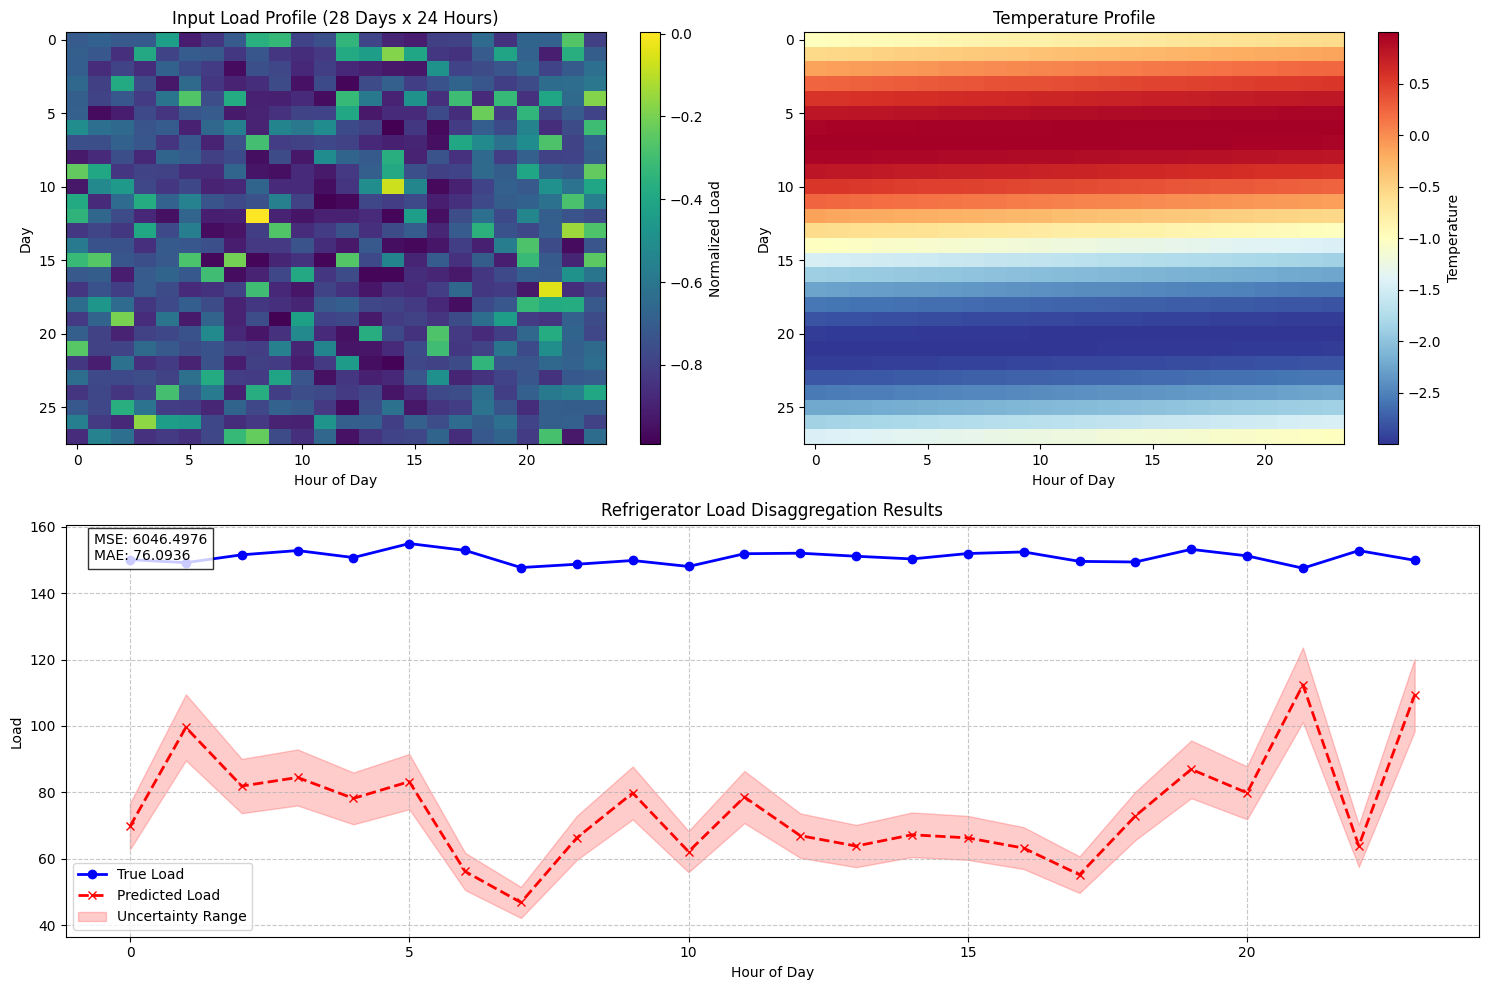


Visualizing multiple samples:
Visualizing 1 samples out of 1 available samples


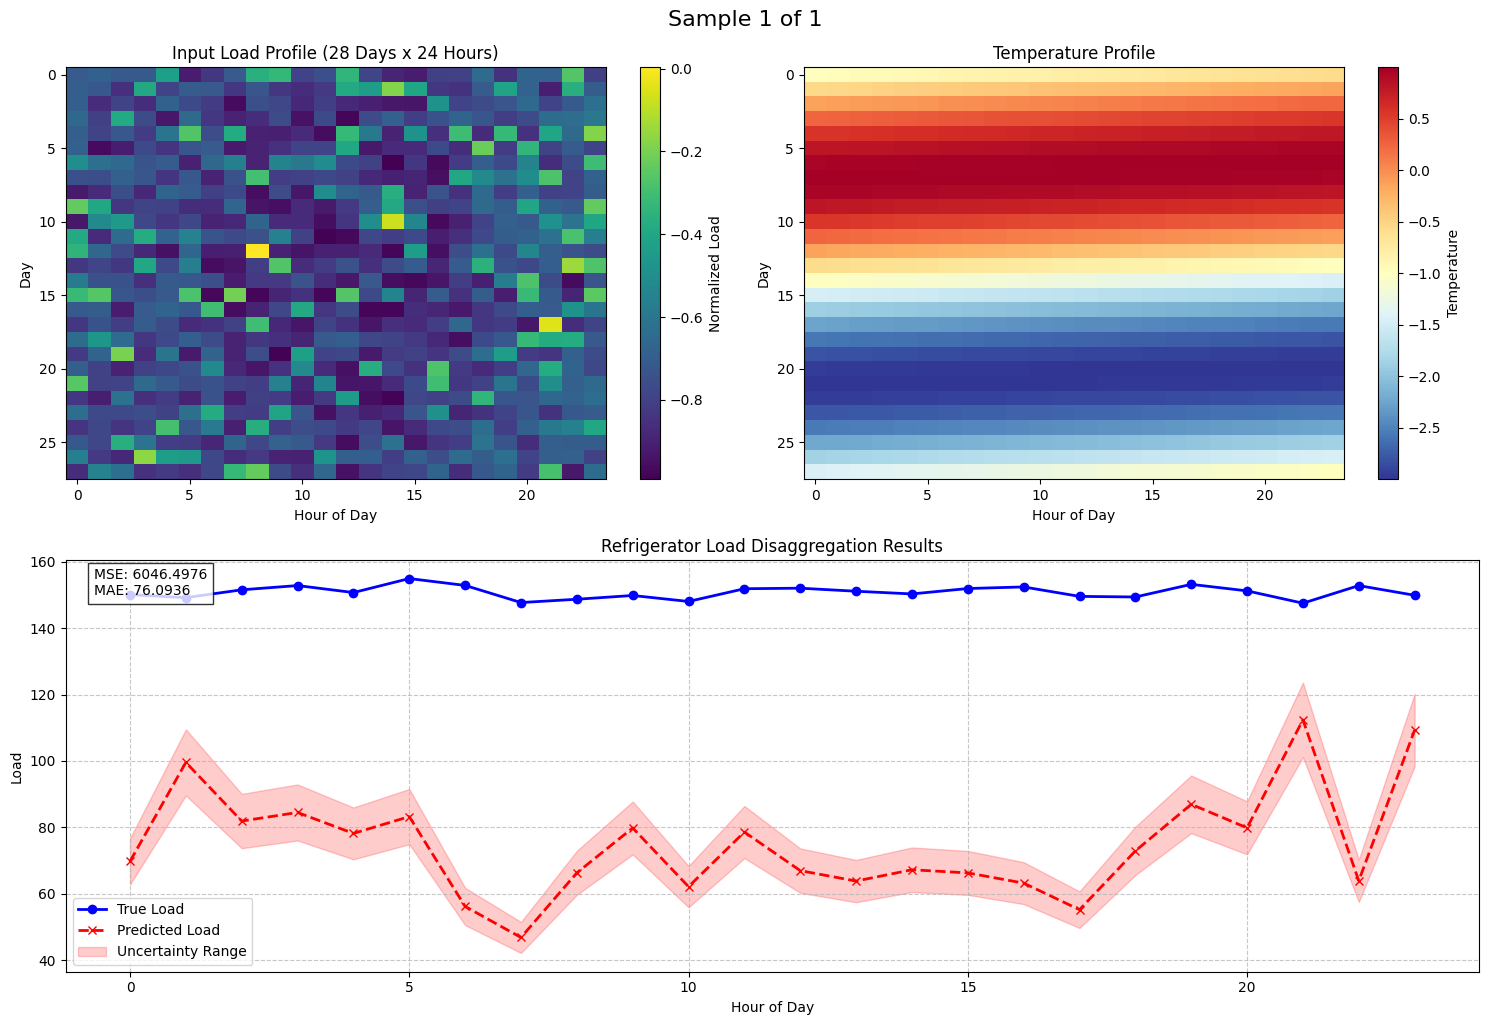

In [14]:
def visualize_disaggregation(model, decoder, dataset, sample_idx=0, device='cpu'):
    model.eval()
    decoder.eval()

    # Check if sample_idx is valid
    if sample_idx >= len(dataset):
        raise IndexError(f"Sample index {sample_idx} is out of range for dataset of size {len(dataset)}")

    # Get sample data
    sample_image, sample_label = dataset[sample_idx]
    sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension
    sample_label = sample_label.to(device)

    # Get prediction
    with torch.no_grad():
        encoded = model(sample_image)
        prediction = decoder(encoded)

    # Move tensors to CPU for plotting
    sample_image = sample_image.cpu()
    sample_label = sample_label.cpu()
    prediction = prediction.cpu()

    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # 1. Input Load Profile Heatmap
    plt.subplot(2, 2, 1)
    plt.imshow(sample_image[0, 0].numpy(), aspect='auto', cmap='viridis')
    plt.colorbar(label='Normalized Load')
    plt.title('Input Load Profile (28 Days x 24 Hours)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day')

    # 2. Temperature Profile Heatmap
    plt.subplot(2, 2, 2)
    plt.imshow(sample_image[0, 1].numpy(), aspect='auto', cmap='RdYlBu_r')
    plt.colorbar(label='Temperature')
    plt.title('Temperature Profile')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day')

    # 3. Disaggregation Results
    plt.subplot(2, 1, 2)
    hours = range(24)

    # Plot true and predicted values
    plt.plot(hours, sample_label.squeeze().numpy(), 'b-',
             label='True Load', linewidth=2, marker='o')
    plt.plot(hours, prediction.squeeze().numpy(), 'r--',
             label='Predicted Load', linewidth=2, marker='x')

    # Add confidence band
    plt.fill_between(hours,
                     prediction.squeeze().numpy() * 0.9,
                     prediction.squeeze().numpy() * 1.1,
                     color='red', alpha=0.2, label='Uncertainty Range')

    plt.title('Refrigerator Load Disaggregation Results')
    plt.xlabel('Hour of Day')
    plt.ylabel('Load')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add error metrics
    mse = nn.MSELoss()(prediction.squeeze(), sample_label.squeeze()).item()
    mae = nn.L1Loss()(prediction.squeeze(), sample_label.squeeze()).item()
    plt.text(0.02, 0.98, f'MSE: {mse:.4f}\nMAE: {mae:.4f}',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')

    plt.tight_layout()
    return fig

def visualize_multiple_samples(model, decoder, dataset, num_samples=3, device='cpu'):
    # Determine the actual number of samples to visualize
    available_samples = len(dataset)
    num_samples = min(num_samples, available_samples)

    if num_samples == 0:
        print("No samples available in the dataset.")
        return

    print(f"Visualizing {num_samples} samples out of {available_samples} available samples")

    for i in range(num_samples):
        try:
            fig = visualize_disaggregation(model, decoder, dataset, sample_idx=i, device=device)
            plt.figure(fig.number)
            plt.suptitle(f'Sample {i+1} of {num_samples}', y=1.02, fontsize=16)
            plt.show()
            plt.close()
        except Exception as e:
            print(f"Error visualizing sample {i}: {str(e)}")
            continue

# Function to plot training history (if available)
def plot_training_history(train_losses, val_losses):
    if not train_losses or not val_losses:
        print("No training history available")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

# Usage example with error handling
try:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    decoder = decoder.to(device)

    # Print dataset sizes
    print(f"Validation dataset size: {len(val_dataset)}")

    # Visualize a single sample
    print("\nVisualizing single sample:")
    visualize_disaggregation(model, decoder, val_dataset, sample_idx=0, device=device)
    plt.show()

    # Visualize multiple samples
    print("\nVisualizing multiple samples:")
    # Adjust num_samples based on your dataset size
    num_samples = min(3, len(val_dataset))
    visualize_multiple_samples(model, decoder, val_dataset, num_samples=num_samples, device=device)

except Exception as e:
    print(f"An error occurred: {str(e)}")

## Some more Visualizations

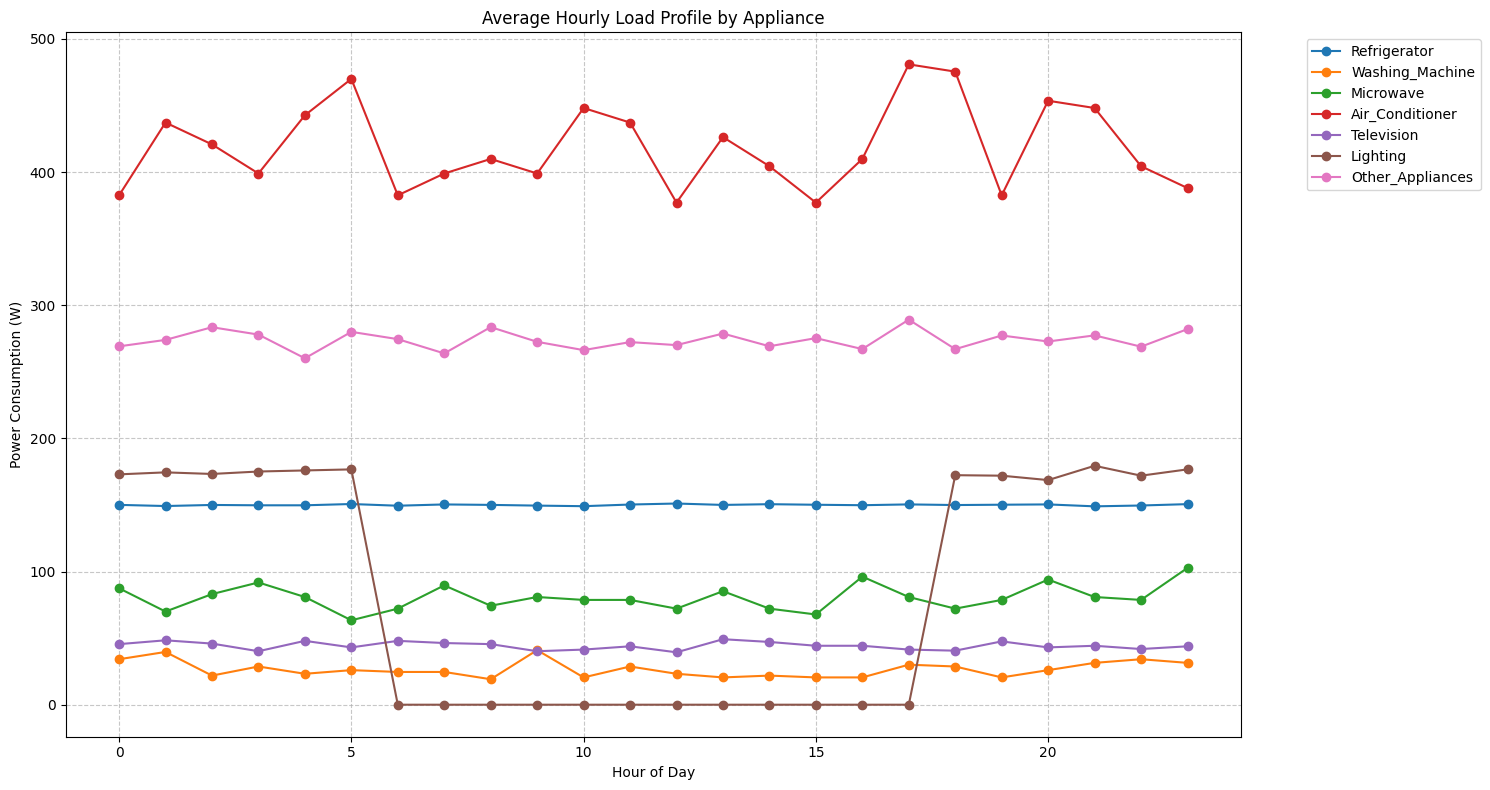

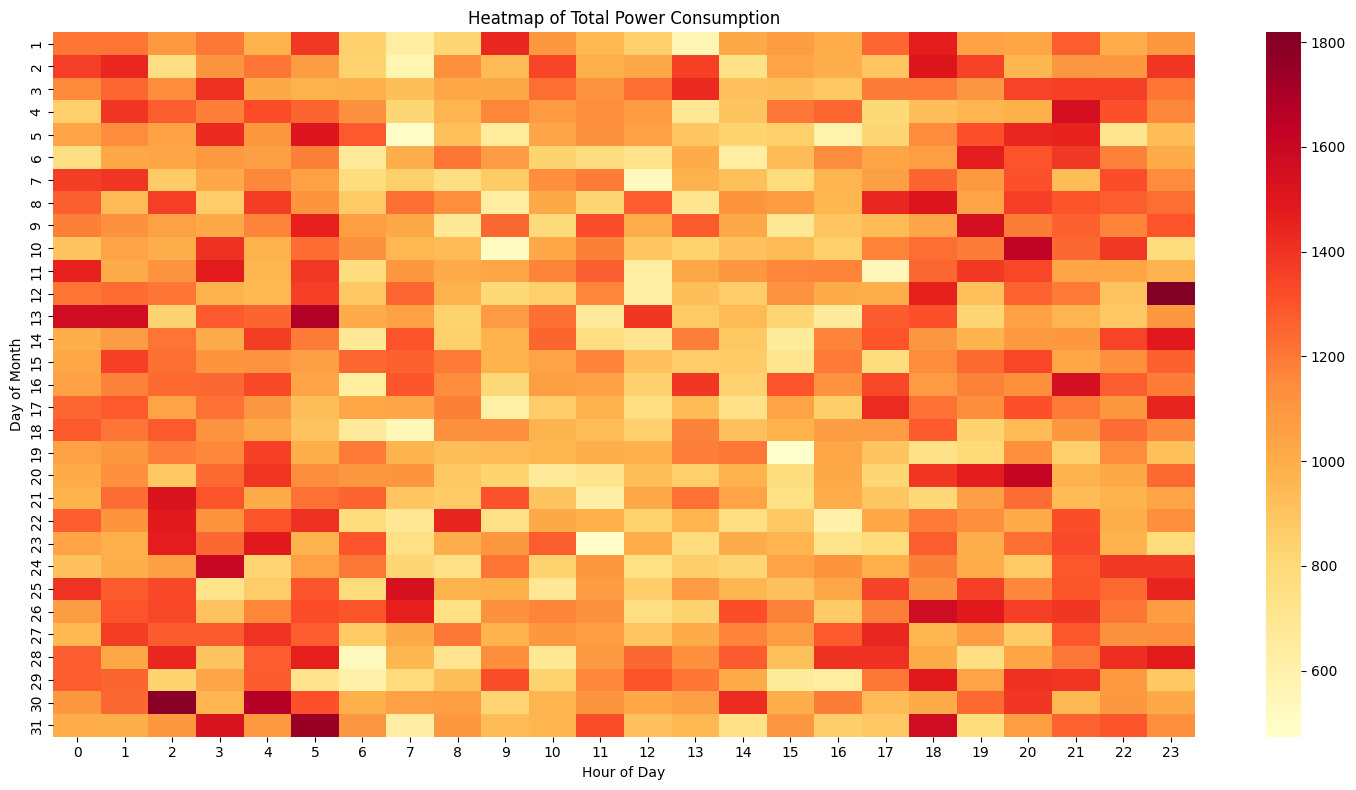

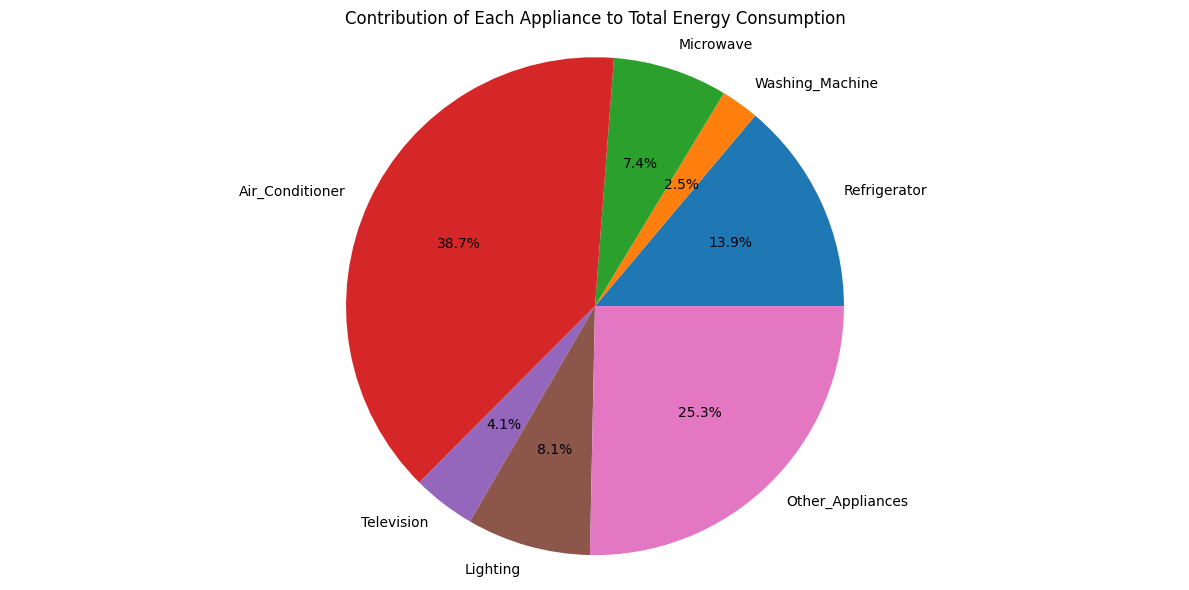

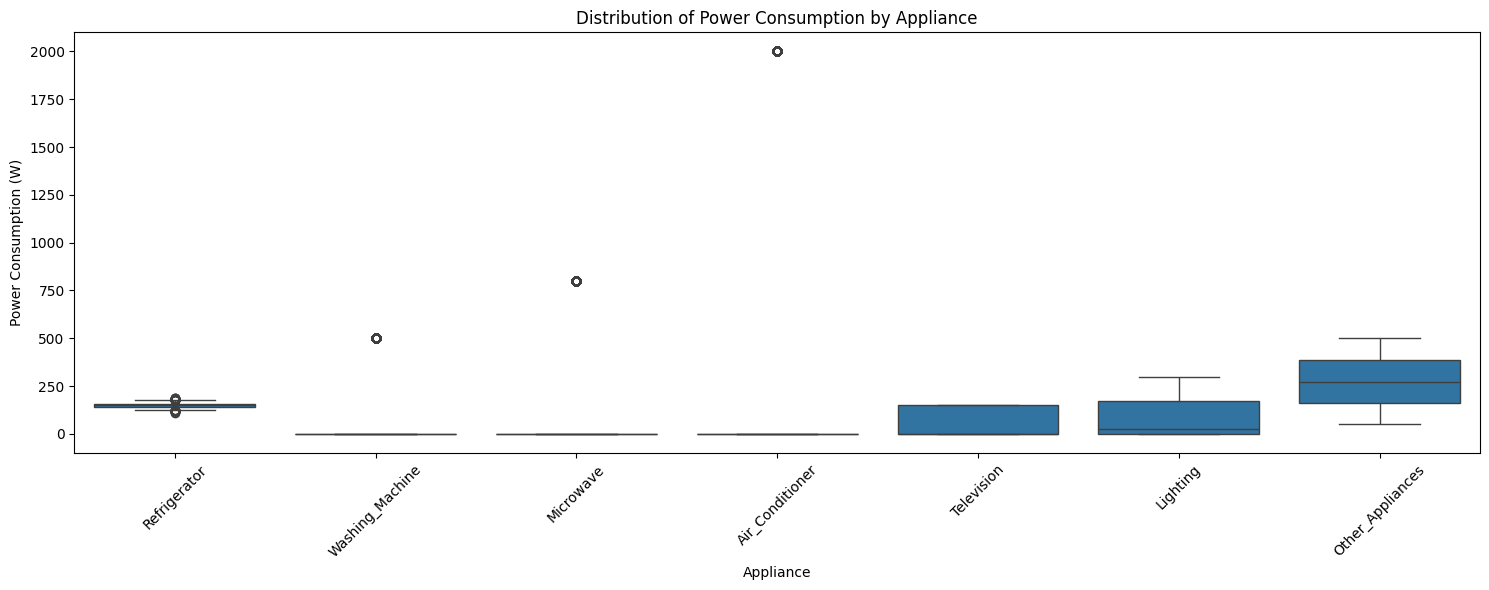

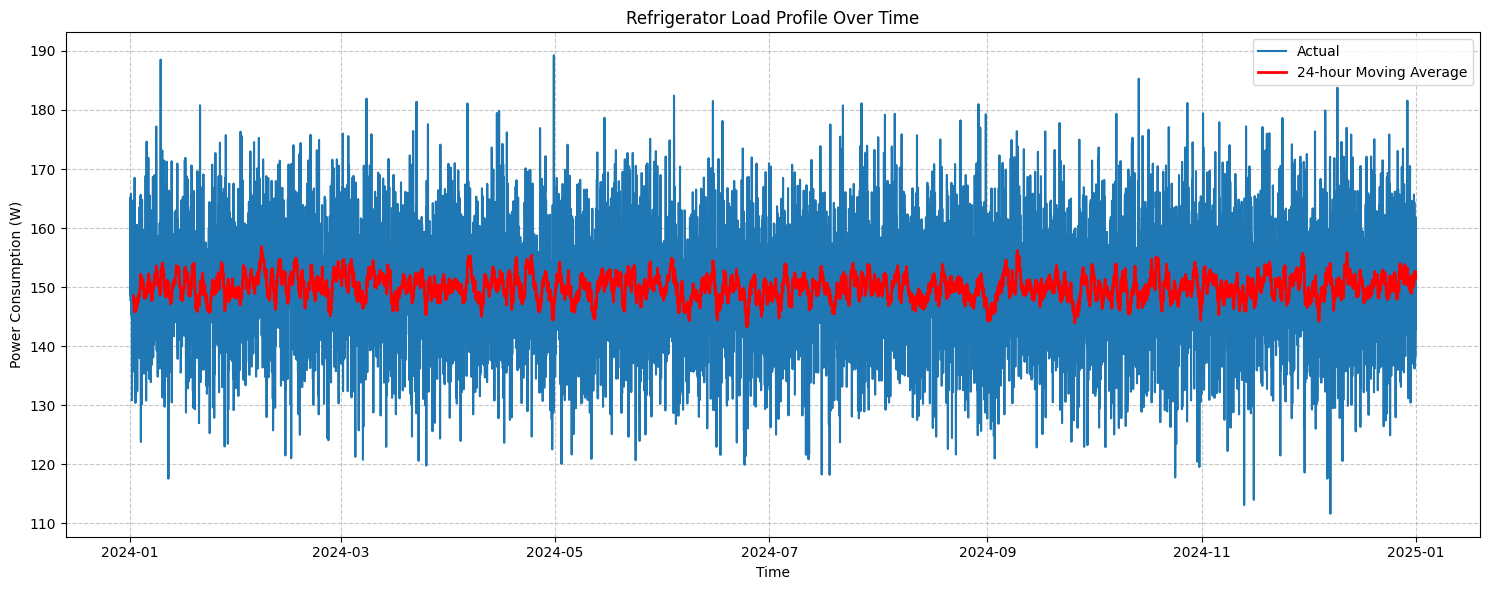

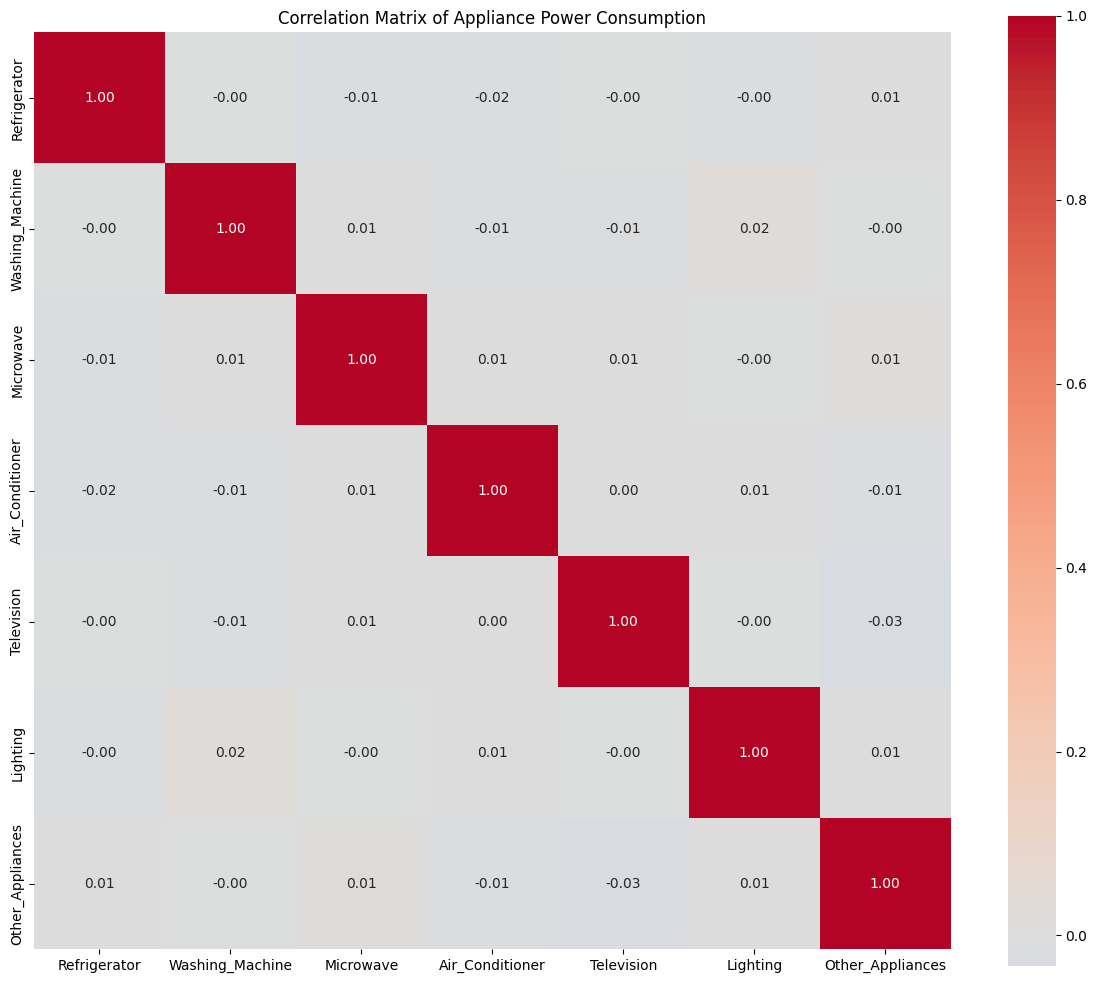

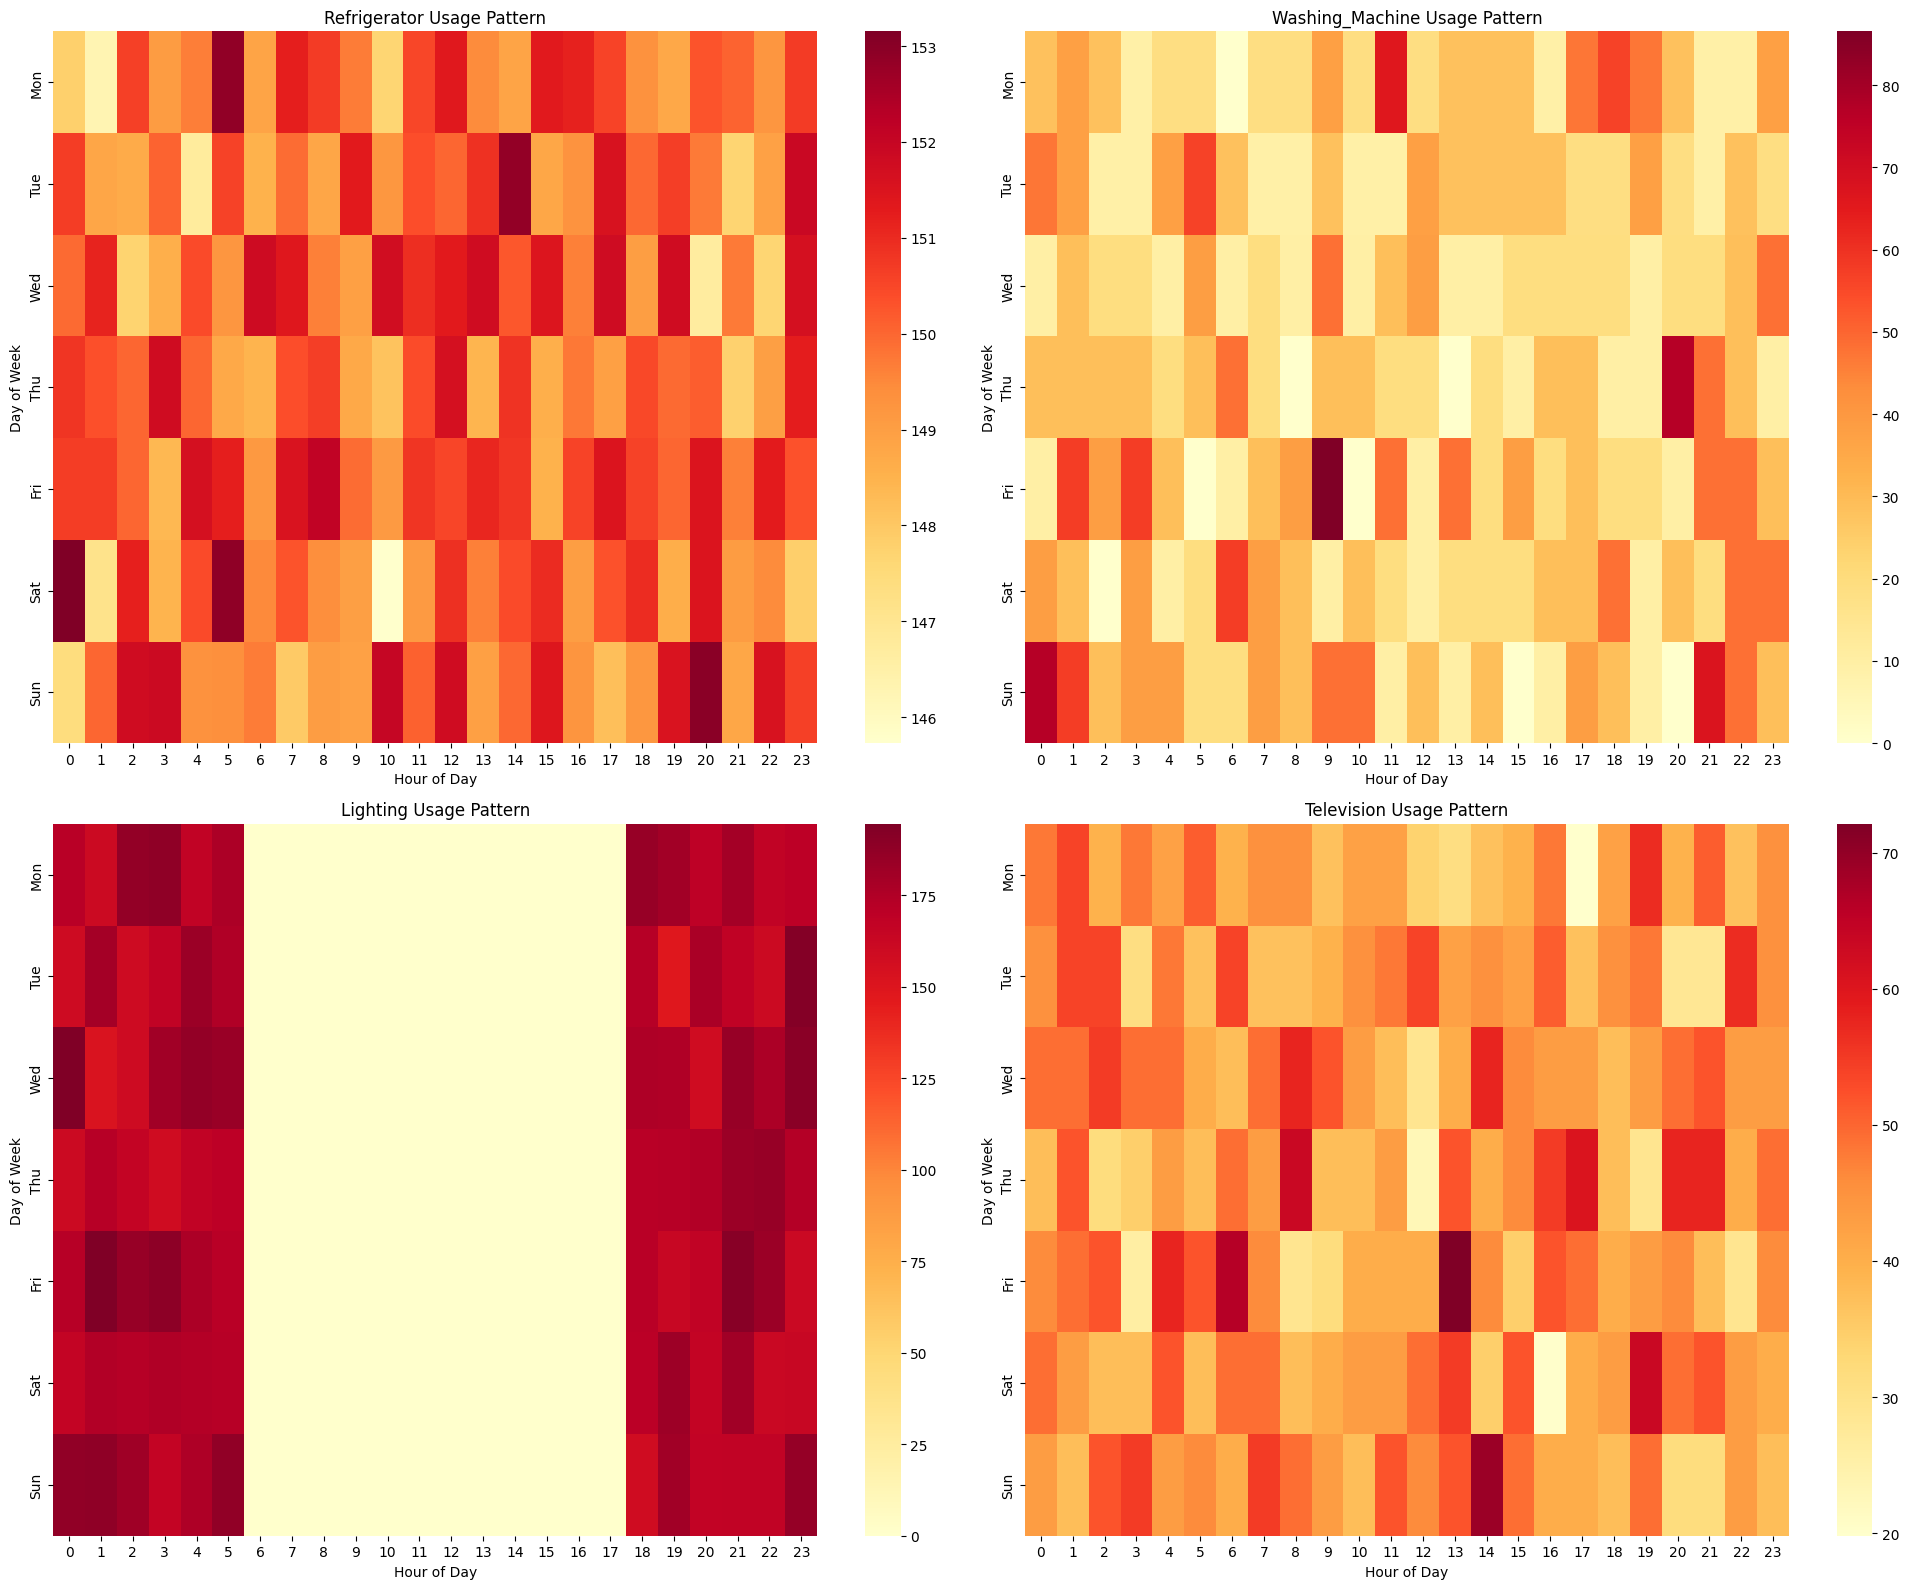


Summary Statistics:
                 Timestamp  Total_Power_Consumption  Refrigerator  \
count                 8784              8784.000000   8784.000000   
mean   2024-07-01 23:30:00              1081.341393    149.998724   
min    2024-01-01 00:00:00               176.910428    111.633445   
25%    2024-04-01 11:45:00               490.146775    143.234753   
50%    2024-07-01 23:30:00               672.694890    149.969197   
75%    2024-10-01 11:15:00              1375.871504    156.802172   
max    2024-12-31 23:00:00              3910.137716    189.262377   
std                    NaN               874.697822     10.103787   

       Washing_Machine    Microwave  Air_Conditioner   Television  \
count      8784.000000  8784.000000      8784.000000  8784.000000   
mean         26.696266    80.510018       418.943534    44.279372   
min           0.000000     0.000000         0.000000     0.000000   
25%           0.000000     0.000000         0.000000     0.000000   
50%         

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def create_visualizations(df):
    # Convert Timestamp to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Add temporal features
    df['Hour'] = df['Timestamp'].dt.hour
    df['Day'] = df['Timestamp'].dt.day
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

    # 1. Daily Load Profile for All Appliances
    plt.figure(figsize=(15, 8))
    appliances = ['Refrigerator', 'Washing_Machine', 'Microwave',
                  'Air_Conditioner', 'Television', 'Lighting', 'Other_Appliances']
    hourly_avg = df.groupby('Hour')[appliances].mean()

    for appliance in appliances:
        plt.plot(hourly_avg.index, hourly_avg[appliance], label=appliance, marker='o')

    plt.title('Average Hourly Load Profile by Appliance')
    plt.xlabel('Hour of Day')
    plt.ylabel('Power Consumption (W)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 2. Heatmap of Hourly Consumption
    plt.figure(figsize=(15, 8))
    pivot_table = df.pivot_table(
        values='Total_Power_Consumption',
        index='Day',
        columns='Hour',
        aggfunc='mean'
    )

    sns.heatmap(pivot_table, cmap='YlOrRd',
                xticklabels=True, yticklabels=True)
    plt.title('Heatmap of Total Power Consumption')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Month')
    plt.tight_layout()
    plt.show()

    # 3. Appliance Contribution to Total Load
    plt.figure(figsize=(12, 6))
    appliance_totals = df[appliances].sum()
    appliance_totals.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Contribution of Each Appliance to Total Energy Consumption')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # 4. Box Plot of Appliance Consumption
    plt.figure(figsize=(15, 6))
    df_melted = df[appliances].melt()
    sns.boxplot(x='variable', y='value', data=df_melted)
    plt.xticks(rotation=45)
    plt.title('Distribution of Power Consumption by Appliance')
    plt.xlabel('Appliance')
    plt.ylabel('Power Consumption (W)')
    plt.tight_layout()
    plt.show()

    # 5. Time Series Plot for Refrigerator
    plt.figure(figsize=(15, 6))
    plt.plot(df['Timestamp'], df['Refrigerator'], label='Actual')

    # Add rolling average
    rolling_mean = df['Refrigerator'].rolling(window=24).mean()
    plt.plot(df['Timestamp'], rolling_mean, label='24-hour Moving Average',
             linewidth=2, color='red')

    plt.title('Refrigerator Load Profile Over Time')
    plt.xlabel('Time')
    plt.ylabel('Power Consumption (W)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 6. Correlation Matrix
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[appliances].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', square=True)
    plt.title('Correlation Matrix of Appliance Power Consumption')
    plt.tight_layout()
    plt.show()

    # 7. Daily Patterns by Appliance
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.ravel()

    for idx, appliance in enumerate(['Refrigerator', 'Washing_Machine',
                                   'Lighting', 'Television']):
        daily_pattern = df.pivot_table(
            values=appliance,
            index='DayOfWeek',
            columns='Hour',
            aggfunc='mean'
        )

        sns.heatmap(daily_pattern, ax=axes[idx], cmap='YlOrRd',
                    xticklabels=True, yticklabels=['Mon', 'Tue', 'Wed', 'Thu',
                                                  'Fri', 'Sat', 'Sun'])
        axes[idx].set_title(f'{appliance} Usage Pattern')
        axes[idx].set_xlabel('Hour of Day')
        axes[idx].set_ylabel('Day of Week')

    plt.tight_layout()
    plt.show()

# Usage
def run_visualization(csv_path):
    # Read the data
    df = pd.read_csv(csv_path, parse_dates=['Timestamp'])

    # Create visualizations
    create_visualizations(df)

    # Print summary statistics
    print("\nSummary Statistics:")
    print(df.describe())

    # Print peak usage times
    print("\nPeak Usage Times:")
    for appliance in df.columns[1:]:  # Skip Timestamp
        peak_hour = df.groupby(df['Timestamp'].dt.hour)[appliance].mean().idxmax()
        print(f"{appliance}: {peak_hour}:00")

# Run the visualizations
run_visualization('/content/energy_disaggregation_data.csv')